In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from scgenome import cncluster
from scdna_replication_tools.plot_utils import get_facs_cmap, get_clone_cmap, plot_colorbar, plot_clustered_cell_cn_matrix, plot_cell_cn_profile2, get_phase_cmap

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 10
despine_trim = True

### Load FACS data and create functions for plotting hmmcopy states and inferred fractions replicated bins

In [3]:
# load data that is split based on their PERT predicted cell cycle phase
cn_pert_s = pd.read_csv('../../analysis/laks_flow/all/cn_s_pyro_inferred_composite_filtered.tsv', sep='\t')
cn_pert_g = pd.read_csv('../../analysis/laks_flow/all/cn_g_pyro_inferred_composite_filtered.tsv', sep='\t')
cn_pert_s['chr'] = cn_pert_s['chr'].astype(str).astype('category')
cn_pert_g['chr'] = cn_pert_g['chr'].astype(str).astype('category')

cn_pert_s['pert_phase'] = 'S'
cn_pert_g['pert_phase'] = 'G1/2'

print(cn_pert_s.shape)

cn_pert_s.head()

(5463062, 36)


,cell_id,chr,start,end,gc,reads,state,copy,sample_id,library_id,...,extreme_cell_frac,cell_frac_rep,rpm_auto,rep_auto,cn_bk,rep_bk,frac_cn0,rpm_auto_norm,rep_auto_norm,pert_phase
0,SA1044-A96139A-R03-C24,1,1500001,2000000,0.539498,783.0,3.0,2.373275,SA1044,A96139A,...,False,0.427159,0.34971,0.04435,144,1014,0.0,-0.027065,NaN,S
1,SA1044-A96139A-R03-C24,1,2000001,2500000,0.594508,835.0,3.0,2.649422,SA1044,A96139A,...,False,0.427159,0.34971,0.04435,144,1014,0.0,-0.027065,NaN,S
2,SA1044-A96139A-R03-C24,1,3000001,3500000,0.584572,934.0,3.0,2.915378,SA1044,A96139A,...,False,0.427159,0.34971,0.04435,144,1014,0.0,-0.027065,NaN,S
3,SA1044-A96139A-R03-C24,1,4000001,4500000,0.482574,606.0,2.0,1.960867,SA1044,A96139A,...,False,0.427159,0.34971,0.04435,144,1014,0.0,-0.027065,NaN,S
4,SA1044-A96139A-R03-C24,1,4500001,5000000,0.481828,439.0,2.0,1.422879,SA1044,A96139A,...,False,0.427159,0.34971,0.04435,144,1014,0.0,-0.027065,NaN,S


In [4]:
# combine the two dataframes and then split them by their FACS phase
cn_facs_all = pd.concat([cn_pert_s, cn_pert_g], ignore_index=True)

cn_facs_s = cn_facs_all.query('cell_cycle_state=="S"')
cn_facs_g = cn_facs_all.query('cell_cycle_state!="S"')
print(cn_facs_s.shape)

cn_facs_s.head()

(6283310, 36)


,cell_id,chr,start,end,gc,reads,state,copy,sample_id,library_id,...,extreme_cell_frac,cell_frac_rep,rpm_auto,rep_auto,cn_bk,rep_bk,frac_cn0,rpm_auto_norm,rep_auto_norm,pert_phase
0,SA1044-A96139A-R03-C24,1,1500001,2000000,0.539498,783.0,3.0,2.373275,SA1044,A96139A,...,False,0.427159,0.34971,0.04435,144,1014,0.0,-0.027065,NaN,S
1,SA1044-A96139A-R03-C24,1,2000001,2500000,0.594508,835.0,3.0,2.649422,SA1044,A96139A,...,False,0.427159,0.34971,0.04435,144,1014,0.0,-0.027065,NaN,S
2,SA1044-A96139A-R03-C24,1,3000001,3500000,0.584572,934.0,3.0,2.915378,SA1044,A96139A,...,False,0.427159,0.34971,0.04435,144,1014,0.0,-0.027065,NaN,S
3,SA1044-A96139A-R03-C24,1,4000001,4500000,0.482574,606.0,2.0,1.960867,SA1044,A96139A,...,False,0.427159,0.34971,0.04435,144,1014,0.0,-0.027065,NaN,S
4,SA1044-A96139A-R03-C24,1,4500001,5000000,0.481828,439.0,2.0,1.422879,SA1044,A96139A,...,False,0.427159,0.34971,0.04435,144,1014,0.0,-0.027065,NaN,S


In [5]:
def plot_facs_hmmcopy_heatmaps(
    cn_g, cn_s, ax_line_g, ax_clone_g, ax_cn_g, ax_line_s, ax_clone_s, ax_cn_s,
    clone_col='clone_id', line_col='sample_id', cn_col='state',
    clone_cmap=get_clone_cmap(), line_cmap=get_facs_cmap(),
    chrom_labels_to_remove=[]
    ):
    ''' 
    Plot HMMcopy heatmaps for FACS isolated S-phase and G1/2-phase cell lines. 
    
    Parameters
    ----------
    cn_g : pandas.DataFrame
        long-form dataframe of G1/2-phase cells with pert model results.
        this dataframe should have the following columns in addition to those specified by additional parameters:
            - chr (categorical)
            - start (int)
            - end (int)
            - cell_id (str)
    cn_s : pandas.DataFrame
        long-form dataframe of S-phase cells with pert model results.
        this dataframe should have the following columns in addition to those specified by additional parameters:
            - chr (categorical)
            - start (int)
            - end (int)
            - cell_id (str)
    ax_line_g : matplitlib.axes.Axes
        axes for the cell line colorbar annotations of G1/2-phase cells
    ax_line_s : matplitlib.axes.Axes
        axes for the cell line colorbar annotations of S-phase cells
    ax_clone_g : matplotlib.axes.Axes
        axes for the G1/2-phase clone ID colorbar annotations
    ax_clone_s : matplotlib.axes.Axes
        axes for the S-phase clone ID colorbar annotations
    ax_cn_g : matplotlib.axes.Axes
        axes for the G1/2-phase CN heatmap
    ax_cn_s : matplotlib.axes.Axes
        axes for the S-phase CN heatmap
    clone_col : str
        column name for clone IDs
    line_col : str
        column name for sample ID or cell line name (e.g. T47D or SA1044)
    cn_col : str
        column name for hmmcopy CN states
    clone_cmap : matplotlib.colors.ListedColormap
        colormap for clone IDs
    site_cmap : matplotlib.colors.ListedColormap
        colormap for sample IDs / cell line
    chrom_labels_to_remove : list
        chromosomes to remove from x-axis to avoid crowding
    '''

    # create mapping of clone IDs
    cluster_col = 'cluster_id'
    clone_dict = dict([(y,x+1) for x,y in enumerate(sorted(cn_g[clone_col].unique()))])
    cn_g[cluster_col] = cn_g[clone_col]
    cn_g = cn_g.replace({cluster_col: clone_dict})
    cn_s[cluster_col] = cn_s[clone_col]
    cn_s = cn_s.replace({cluster_col: clone_dict})

    # plot the CN states for the S-phase cells
    plot_data_cn_s = plot_clustered_cell_cn_matrix(
        ax_cn_s, cn_s, cn_col, cluster_field_name=cluster_col, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # plot the CN states for the G1/2-phase cells
    plot_data_cn_g = plot_clustered_cell_cn_matrix(
        ax_cn_g, cn_g, cn_col, cluster_field_name=cluster_col, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # turn off the y-axis ticks in all subplots
    for ax in [ax_cn_s, ax_cn_g, ax_clone_s, ax_clone_g, ax_line_s, ax_line_g]:
        ax.set_yticks([])
        ax.set_ylabel('')

    # add the colorbars for clone_id and model_tau
    if len(clone_dict) > 1:
        cell_ids_g = plot_data_cn_g.columns.get_level_values(0).values
        cluster_ids_g = plot_data_cn_g.columns.get_level_values(1).values
        # use mcolors to change every element in the dict to rgba
        for key in clone_cmap.keys():
            clone_cmap[key] = mcolors.to_rgba(clone_cmap[key])
        color_mat_g, _ = cncluster.get_cluster_colors(cluster_ids_g, color_map=clone_cmap, return_map=True)

        # get array of the site values that match the cell_id order
        condensed_cn_g = cn_g[['cell_id', line_col]].drop_duplicates()
        line_array_g = []
        for cell in cell_ids_g:
            line = condensed_cn_g[condensed_cn_g['cell_id'] == cell][line_col].values[0]
            line_array_g.append(line)
        
        # use mcolors to change every element of the site cmap dict to rgba
        for key in line_cmap.keys():
            line_cmap[key] = mcolors.to_rgba(line_cmap[key])
        line_color_mat_g, _ = cncluster.get_cluster_colors(line_array_g, color_map=line_cmap, return_map=True)

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_clone_g, color_mat_g)

        # create color bar that shows site for each row in heatmap
        plot_colorbar(ax_line_g, line_color_mat_g)

        # repeat for the S-phase cells
        cell_ids_s = plot_data_cn_s.columns.get_level_values(0).values
        cluster_ids_s = plot_data_cn_s.columns.get_level_values(1).values
        color_mat_s, _ = cncluster.get_cluster_colors(cluster_ids_s, color_map=clone_cmap, return_map=True)

        # get array of the site values that match the cell_id order
        condensed_cn_s = cn_s[['cell_id', line_col]].drop_duplicates()
        line_array_s = []
        for cell in cell_ids_s:
            line = condensed_cn_s[condensed_cn_s['cell_id'] == cell][line_col].values[0]
            line_array_s.append(line)

        line_color_mat_s, _ = cncluster.get_cluster_colors(line_array_s, color_map=line_cmap, return_map=True)

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_clone_s, color_mat_s)

        # create color bar that shows site for each row in heatmap
        plot_colorbar(ax_line_s, line_color_mat_s)
    
    # set clone and time as the xtick labels for ax11 and ax10, respectively
    ax_clone_s.set_xticks([0.0])
    ax_clone_s.set_xticklabels(['clone'], rotation=90)
    ax_clone_g.set_xticks([0.0])
    ax_clone_g.set_xticklabels(['clone'], rotation=90)
    ax_line_s.set_xticks([0.0])
    ax_line_s.set_xticklabels(['cell line'], rotation=90)
    ax_line_g.set_xticks([0.0])
    ax_line_g.set_xticklabels(['cell line'], rotation=90)
    ax_cn_s.set_xlabel('chromosome')
    ax_cn_g.set_xlabel('chromosome')
    ax_line_s.set_ylabel('{} FACS S-phase cells'.format(cn_s.cell_id.nunique()))
    ax_line_g.set_ylabel('{} FACS G1/2-phase cells'.format(cn_g.cell_id.nunique()))
    ax_cn_s.set_title('HMMcopy states')
    ax_cn_g.set_title('HMMcopy states')

In [6]:
cell_facs_df = cn_facs_all[['cell_id', 'sample_id', 'clone_id', 'cell_cycle_state', 'pert_phase', 'cell_frac_rep']].drop_duplicates()
cell_facs_df['cell_line'] = cell_facs_df['sample_id'].apply(lambda x: 'T47D' if x=='SA1044' else 'GM18507')
cell_facs_df[['cell_line', 'sample_id']].value_counts()

cell_line  sample_id
T47D       SA1044       1833
GM18507    SA928        1566
dtype: int64

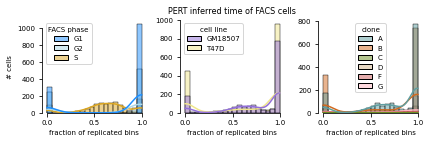

In [7]:
def plot_facs_frac_rep_histograms(cell_facs_df, ax_phase, ax_line, ax_clone):
    # plot a histogram of each cell's fraction of replicated bins, split by FACS phase, cell line, and clone
    for ax, hue_name, legend_title, cmap in zip(
        [ax_phase, ax_line, ax_clone], 
        ['cell_cycle_state', 'cell_line', 'clone_id'], 
        ['FACS phase', 'cell line', 'clone'],
        [get_phase_cmap(), get_facs_cmap(), get_clone_cmap()]
        ):
        cell_facs_df[legend_title] = cell_facs_df[hue_name]
        hue_order = sorted(cell_facs_df[hue_name].unique())
        g = sns.histplot(data=cell_facs_df, x='cell_frac_rep', hue=legend_title, hue_order=hue_order, palette=cmap, ax=ax, kde=True, bins=20)
        ax.set_xlabel('fraction of replicated bins')
        # h, l = ax.get_legend_handles_labels()
        # ax.legend(title=legend_title, frameon=False, labels=cell_facs_df[hue_name].unique(), handles=cmap)
        # g.legend(frameon=False)
        sns.despine(ax=ax, offset=0, trim=despine_trim)

    ax_phase.set_ylabel('# cells')
    ax_line.set_title('PERT inferred time of FACS cells')

    for ax in [ax_line, ax_clone]:
        ax.set_ylabel('')
    #     ax.set_yticklabels([])


fig, ax = plt.subplots(1, 3, figsize=(6, 2), tight_layout=True)
plot_facs_frac_rep_histograms(cell_facs_df, ax[0], ax[1], ax[2])
plt.show()

### Load data and make plotting code for showing how RT profiles of the FACS cell line vary between split and merged input

In [8]:
rt_facs = pd.read_csv('../../analysis/laks_flow/all/rt_pseudobulks_composite.tsv', sep='\t')
rt_facs['chr'] = rt_facs['chr'].astype(str).astype('category')
rt_facs.head()

,chr,start,end,gc,rt_merged_T47D,rt_merged_GM18507,rt_split_T47D,rt_split_GM18507,rt_diff_split,rt_diff_merged
0,1,1500001,2000000,0.539498,0.997658,0.980392,0.997685,0.978896,0.018789,0.017266
1,1,2000001,2500000,0.594508,0.997658,0.985294,0.997685,0.985390,0.012296,0.012364
2,1,3000001,3500000,0.584572,0.990632,0.919935,0.997685,0.842532,0.155153,0.070698
3,1,4000001,4500000,0.482574,0.878220,0.808824,0.881944,0.795455,0.086490,0.069397
4,1,4500001,5000000,0.481828,0.358314,0.433007,0.347222,0.441558,-0.094336,-0.074693


/data1/shahs3/users/weinera2/scdna_replication_tools/venv/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/data1/shahs3/users/weinera2/scdna_replication_tools/venv/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/data1/shahs3/users/weinera2/scdna_replication_tools/venv/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categ

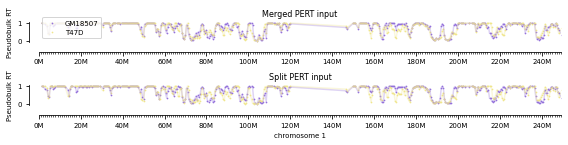

In [9]:
def plot_chr1_by_cell_line(df, ax_merged, ax_split):
    cell_line_cmap = get_facs_cmap()

    # plot chr1 bulk RT for each cell line inferred with the merged model
    plot_cell_cn_profile2(ax_merged, df, 'rt_merged_GM18507', color=cell_line_cmap['GM18507'], label='GM18507', rawy=True, max_cn=None, scale_data=False, lines=True, chromosome='1', s=0.5, rasterized=True)
    plot_cell_cn_profile2(ax_merged, df, 'rt_merged_T47D', color=cell_line_cmap['T47D'], label='T47D', rawy=True, max_cn=None, scale_data=False, lines=True, chromosome='1', s=0.5, rasterized=True)
    ax_merged.set_ylabel('Pseudobulk RT')
    ax_merged.set_title('Merged PERT input')
    ax_merged.legend(loc='lower left')
    ax_merged.set_xlabel('')

    # plot chr1 bulk RT for each cell line inferred with the split model
    plot_cell_cn_profile2(ax_split, df, 'rt_split_GM18507', color=cell_line_cmap['GM18507'], label='GM18507', rawy=True, max_cn=None, scale_data=False, lines=True, chromosome='1', s=0.5, rasterized=True)
    plot_cell_cn_profile2(ax_split, df, 'rt_split_T47D', color=cell_line_cmap['T47D'], label='T47D', rawy=True, max_cn=None, scale_data=False, lines=True, chromosome='1', s=0.5, rasterized=True)
    ax_split.set_ylabel('Pseudobulk RT')
    ax_split.set_title('Split PERT input')
    # ax_split.legend()

fig, ax = plt.subplots(2, 1, figsize=(8, 2), tight_layout=True)
plot_chr1_by_cell_line(rt_facs, ax[0], ax[1])
plt.show()

### Load data and create functions to show the simulated datasets with clone RT profiles taken from different ENCODE cell lines

In [10]:
df10 = pd.read_csv('../../analysis/simulation/P10/scRT_pseudobulks_pyro_composite.tsv', sep='\t')
df11 = pd.read_csv('../../analysis/simulation/P11/scRT_pseudobulks_pyro_composite.tsv', sep='\t')
df10['chr'] = df10['chr'].astype(str).astype('category')
df11['chr'] = df11['chr'].astype(str).astype('category')
df10.head()

,chr,start,pseduobulk_model_rep_state,pseduobulk_hours,pseduobulk_cloneA_model_rep_state,pseduobulk_cloneA_hours,pseduobulk_cloneB_model_rep_state,pseduobulk_cloneB_hours,pseduobulk_cloneC_model_rep_state,pseduobulk_cloneC_hours,...,true_pseduobulk_true_rep,true_pseduobulk_hours,true_pseduobulk_cloneA_true_rep,true_pseduobulk_cloneA_hours,true_pseduobulk_cloneB_true_rep,true_pseduobulk_cloneB_hours,true_pseduobulk_cloneC_true_rep,true_pseduobulk_cloneC_hours,true_pseduobulk_cloneD_true_rep,true_pseduobulk_cloneD_hours
0,1,2000000,0.760,1.622419,0.718447,2.500000,0.731183,2.023810,0.806452,1.325301,...,0.8300,1.323944,0.747573,2.371134,0.827957,1.477273,0.849462,1.379310,0.891892,0.934579
1,1,4500000,0.185,8.407080,0.135922,8.750000,0.139785,8.571429,0.204301,8.072289,...,0.2175,8.225352,0.145631,8.762887,0.193548,8.181818,0.225806,8.045977,0.297297,7.102804
2,1,6500000,0.785,1.327434,0.796117,1.666667,0.752688,1.785714,0.774194,1.686747,...,0.8275,1.352113,0.796117,1.855670,0.817204,1.590909,0.817204,1.724138,0.873874,1.121495
3,1,7500000,0.540,4.218289,0.524272,4.583333,0.559140,3.928571,0.494624,4.819277,...,0.5725,4.225352,0.504854,4.948454,0.623656,3.636364,0.505376,5.057471,0.648649,3.457944
4,1,8000000,0.720,2.094395,0.708738,2.604167,0.688172,2.500000,0.677419,2.771084,...,0.7625,2.084507,0.708738,2.783505,0.763441,2.159091,0.709677,2.873563,0.855856,1.308411


In [11]:
# process the data from df10 and df11
# subset to just the acceptable columns in each dataset
good_cols = [
    'chr', 'start', 
    'pseduobulk_cloneA_model_rep_state', 'true_pseduobulk_cloneA_true_rep',
    'pseduobulk_cloneB_model_rep_state', 'true_pseduobulk_cloneB_true_rep',
    'pseduobulk_cloneC_model_rep_state', 'true_pseduobulk_cloneC_true_rep',
    'pseduobulk_cloneD_model_rep_state', 'true_pseduobulk_cloneD_true_rep'
]

df10 = df10[good_cols]
df11 = df11[good_cols]

# remove the 'true_' from the 'true_pseduobulk_' prefix from the true replication columns
df10.columns = df10.columns.str.replace('true_pseduobulk', 'pseduobulk')
df11.columns = df11.columns.str.replace('true_pseduobulk', 'pseduobulk')

# correct the pseudobulk typo
df10.columns = df10.columns.str.replace('pseduobulk', 'pseudobulk')
df11.columns = df11.columns.str.replace('pseduobulk', 'pseudobulk')

# create a dict that maps the clone names to the cell lines used in the simulation
# for dataset 10
clone_to_cell_line_10 = {
    'cloneA': 'gm06990_P10',
    'cloneB': 'gm12801_P10',
    'cloneC': 'gm12812_P10',
    'cloneD': 'gm12813_P10'
}

# for dataset 11
clone_to_cell_line_11 = {
    'cloneA': 'bj_P11',
    'cloneB': 'mcf7_P11',
    'cloneC': 'hepg2_P11',
    'cloneD': 'gm12813_P11'
}

# use these two dicts to rename the columns in each dataset wherever the substring 'clone' appears
df10 = df10.rename(columns={col: col.replace('clone', clone_to_cell_line_10[col.split('_')[1]]) for col in df10.columns if 'clone' in col})
df11 = df11.rename(columns={col: col.replace('clone', clone_to_cell_line_11[col.split('_')[1]]) for col in df11.columns if 'clone' in col})

# merge the two datasets on the chr and start columns
rt_sim = pd.merge(df10, df11, on=['chr', 'start'])

# convert chr column to category
rt_sim['chr'] = rt_sim['chr'].astype('category')
rt_sim['end'] = rt_sim['start'] + 500000 - 1

# drop the 'pseudobulk_' prefix from the columns
rt_sim.columns = rt_sim.columns.str.replace('pseudobulk_', '')

# rename the 'model_rep_state' suffix to 'inferred'
rt_sim.columns = rt_sim.columns.str.replace('model_rep_state', 'inferred')

# rename the 'true_rep' suffix to 'true'
rt_sim.columns = rt_sim.columns.str.replace('true_rep', 'true')


In [12]:
def plot_rt_sim_corr_heatmap(df, ax):
    # compute the pairwise correlation between all of the columns except the chr and start columns
    corr = df.corr()

    # drop the 'start' and 'end' rows and columns from the correlation matrix
    corr = corr.drop('start', axis=0)
    corr = corr.drop('start', axis=1)
    corr = corr.drop('end', axis=0)
    corr = corr.drop('end', axis=1)

    # replace the underscores in the column and row names with spaces
    corr.columns = corr.columns.str.replace('_', ' ')
    corr.index = corr.index.str.replace('_', ' ')

    # mask the upper triangle of the heatmap
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # plot the heatmap, including the first 2 digits of the correlation values
    sns.heatmap(corr, square=False, linewidths=.5, cbar_kws={"shrink": .5, 'label': 'Pearson r'}, mask=mask, annot=False, fmt='.2f', ax=ax, cmap='Blues', vmin=0.5, vmax=1)
    ax.set_title('True vs inferred RT correlations\nsimulated data with clone-specific RT')
    ax.set_xlabel('ENCODE cell line + permuted dataset ID + clone ID + true/inferred')
    # ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)


In [13]:
def plot_true_vs_inferred_rt_profiles(df, ax0, ax1, ax2):
    # plot true vs inferred RT profiles for three separate clones
    true_color = 'black'
    inferred_color = 'orange'
    chrom = '1'

    # compare gm06990_P10A_true and gm06990_P10A_inferred in ax0
    plot_cell_cn_profile2(
        ax0, df, 'gm06990_P10A_true', color=true_color, chromosome=chrom, rawy=True,
        max_cn=None, scale_data=False, lines=True, label='true', s=0.5, rasterized=True
    )
    plot_cell_cn_profile2(
        ax0, df, 'gm06990_P10A_inferred', color=inferred_color, chromosome=chrom, rawy=True,
        max_cn=None, scale_data=False, lines=True, label='inferred', s=0.5, rasterized=True
    )
    ax0.set_title('Clone with GM06990 RT')
    ax0.legend(loc='lower left')
    
    # compare hepg2_P11C_true and hepg2_P11C_inferred in ax1
    plot_cell_cn_profile2(
        ax1, df, 'hepg2_P11C_true', color=true_color, chromosome=chrom, rawy=True,
        max_cn=None, scale_data=False, lines=True, label='true', s=0.5, rasterized=True
    )
    plot_cell_cn_profile2(
        ax1, df, 'hepg2_P11C_inferred', color=inferred_color, chromosome=chrom, rawy=True,
        max_cn=None, scale_data=False, lines=True, label='inferred', s=0.5, rasterized=True
    )
    ax1.set_title('Clone with HEPG2 RT')

    # compare mcf7_P11B_true and mcf7_P11B_inferred in ax2
    plot_cell_cn_profile2(
        ax2, df, 'mcf7_P11B_true', color=true_color, chromosome=chrom, rawy=True,
        max_cn=None, scale_data=False, lines=True, label='true', s=0.5, rasterized=True
    )
    plot_cell_cn_profile2(
        ax2, df, 'mcf7_P11B_inferred', color=inferred_color, chromosome=chrom, rawy=True,
        max_cn=None, scale_data=False, lines=True, label='inferred', s=0.5, rasterized=True
    )
    ax2.set_title('Clone with MCF7 RT')

    for ax in [ax0, ax1, ax2]:
        ax.set_ylabel('Pseudobulk RT')
    for ax in [ax0, ax1]:
        ax.set_xlabel('')

### Load and plot data showing results from the FACS permutation experiments

In [14]:
rt_perm = pd.read_csv('../../analysis/laks_flow/permuted/rt_pseudobulks_composite.tsv', sep='\t')

# remove columns that should not appear in the correlation matrix
bad_columns = ['chr', 'start', 'end', 'gc', 'rt_split_T47D', 'rt_split_GM18507', 'rt_diff_split', 'rt_diff_merged']
rt_perm = rt_perm.drop(columns=bad_columns)

# rename the reference dataset columns with no permuted cells
rt_perm = rt_perm.rename(columns={
    'rt_merged_T47D': 'T47D',
    'rt_merged_GM18507': 'GM18507',
})

# replace all the underscores with spaces in the column names
rt_perm.columns = [col.replace('_', ' ') for col in rt_perm.columns]

# compute the pairwise correlation between all bulk rt columns
# sort the columns before computing the correlaiton to ensure the same order
rt_perm_corr = rt_perm[sorted(rt_perm.columns)].corr()

In [15]:
def plot_rt_perm_corr(corr, ax):
    # mask the upper triangle of the heatmap
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # plot the heatmap of pearson correlations
    sns.heatmap(corr, square=False, linewidths=.1, cbar_kws={"shrink": .5, 'label': 'Pearson r'}, mask=mask, annot=False, fmt='.2f', ax=ax, cmap='Blues', vmin=0.5, vmax=1)
    ax.set_title('Cell line RT correlations\nin permuted datasets')
    ax.set_xlabel('cell line + permuted dataset ID')


In [16]:
metrics_df = pd.read_csv('../../analysis/laks_flow/permuted/cell_metrics.tsv', sep='\t')

metrics_df['FACS phase'] = metrics_df['true_cell_cycle_state']
# create a new column entitled 'PERT phase' that is 'G' when extreme_cell_frac is True and 'S' when extreme_cell_frac is False
metrics_df['PERT phase'] = metrics_df['extreme_cell_frac'].apply(lambda x: 'G1/2' if x else 'S')

# rename the columns in metrics df to make the plots more readable
metrics_df.rename(columns={
    'Laks S-phase probability': 'Laks S prob',
    'CN breakpoints': 'HMMcopy breakpoints',
    'RPM median absolute deviation': 'MADN RPM',
    'Laks quality score': 'Laks quality',
    }, inplace=True)

metrics_df.head()

,cell_id,cell_frac_rep,true_cell_cycle_state,cell_cycle_state,total_mapped_reads_hmmcopy,breakpoints,Laks S prob,madn,lrs,MADN RPM,HMMcopy breakpoints,Laks quality,extreme_cell_frac,filtered,permuted,dataset,Flow phase,PERT phase,FACS phase
0,SA1044-A96139A-R03-C24,0.427539,S,S,4051050,498,0.925614,0.105252,0.342193,0.004589,397.04386,0.402,False,False,False,A,S,S,S
1,SA1044-A96139A-R03-C28,0.528528,S,S,3830476,232,0.942515,0.101584,0.331651,-0.003676,131.04386,0.430,False,False,False,A,S,S,S
2,SA1044-A96139A-R03-C31,0.528338,S,S,2880595,391,0.894417,0.120130,0.166376,-0.004924,290.04386,0.316,False,False,False,A,S,S,S
3,SA1044-A96139A-R03-C34,0.697413,S,S,2943686,259,0.803041,0.102835,0.247393,-0.020904,158.04386,0.316,False,False,False,A,S,S,S
4,SA1044-A96139A-R04-C23,0.770065,S,S,3774165,225,0.294651,0.093192,0.194893,-0.013241,124.04386,0.704,False,False,False,A,S,S,S


In [17]:
def plot_perm_cell_metrics(metrics_df, ax0, ax1, ax2, ax3, ax4, ax5, s=0.5):
    phase_cmap = get_phase_cmap()
    # plot the distributions of each cell metric
    sns.scatterplot(data=metrics_df.query("permuted==True"), x='Laks S prob', y='Laks quality', hue='PERT phase', alpha=0.5, ax=ax0, palette=phase_cmap, s=s, rasterized=True)
    sns.scatterplot(data=metrics_df.query("permuted==True"), x='HMMcopy breakpoints', y='Laks quality', hue='PERT phase', alpha=0.5, ax=ax1, palette=phase_cmap, s=s, rasterized=True)
    sns.scatterplot(data=metrics_df.query("permuted==True"), x='MADN RPM', y='Laks quality', hue='PERT phase', alpha=0.5, ax=ax2, palette=phase_cmap, s=s, rasterized=True)
    sns.scatterplot(data=metrics_df.query("permuted==True"), x='Laks S prob', y='MADN RPM', hue='PERT phase', alpha=0.5, ax=ax3, palette=phase_cmap, s=s, rasterized=True)
    sns.scatterplot(data=metrics_df.query("permuted==True"), x='HMMcopy breakpoints', y='Laks S prob', hue='PERT phase', alpha=0.5, ax=ax4, palette=phase_cmap, s=s, rasterized=True)
    sns.scatterplot(data=metrics_df.query("permuted==True"), x='MADN RPM', y='HMMcopy breakpoints', hue='PERT phase', alpha=0.5, ax=ax5, palette=phase_cmap, s=s, rasterized=True)

    ax1.set_title('Orthogonal cell cycle features of mislabeled FACS G1/2 cells')
    ax2.legend(title='PERT phase', loc='upper right', frameon=True)

    for i in range(6):
        ax = eval('ax{}'.format(i))
        sns.despine(ax=ax, offset=5, trim=despine_trim)
        if i!=2:
            ax.legend_.remove()
        
    

/data1/shahs3/users/weinera2/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data1/shahs3/users/weinera2/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/data1/shahs3/users/weinera2/scdna_replication_tools/scdna_replication_tools/plot_utils.py:232: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously l

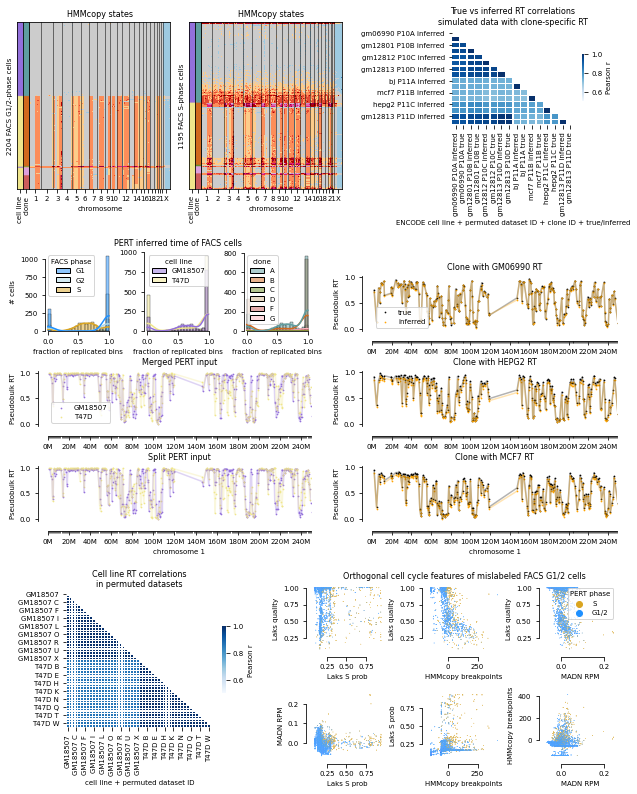

In [18]:
# create a large 8.5 x 11 figure and manually add all the subplots with custom positioning
# since I'm adding labels the figure will be slightly larger than the specified size,
# thus I need to divide the width and height by a multiplicative factor to get the correct size
mult_factor = 1.0
fig = plt.figure(figsize=(8.5/mult_factor, 11/mult_factor))

# add hmmcopy heatmaps for the T47D and GM18507 cells
# G1/2-phase cells on the left, S-phase cells on the right
# both heatmaps have colorbar annotations for cell line and clone
ax0 = fig.add_axes([0.02, 0.77, 0.01, 0.21])
# ax0.set_title('ax0')
ax1 = fig.add_axes([0.03, 0.77, 0.01, 0.21])
# ax1.set_title('ax1')
ax2 = fig.add_axes([0.04, 0.77, 0.23, 0.21])
# ax2.set_title('ax2')

ax3 = fig.add_axes([0.3, 0.77, 0.01, 0.21])
# ax3.set_title('ax3')
ax4 = fig.add_axes([0.31, 0.77, 0.01, 0.21])
# ax4.set_title('ax4')
ax5 = fig.add_axes([0.32, 0.77, 0.23, 0.21])
# ax5.set_title('ax5')

# add three subplots below the hmmcopy heatmaps
ax6 = fig.add_axes([0.065, 0.59, 0.11, 0.1])
# ax6.set_title('ax6')
ax7 = fig.add_axes([0.2275, 0.59, 0.11, 0.1])
# ax7.set_title('ax7')
ax8 = fig.add_axes([0.39, 0.59, 0.11, 0.1])
# ax8.set_title('ax8')

# two rt profiles underneath ax6-7
ax9 = fig.add_axes([0.07, 0.47, 0.43, 0.07])
ax9.set_title('ax9')
ax10 = fig.add_axes([0.07, 0.35, 0.43, 0.07], sharey=ax9)
ax10.set_title('ax10')

# a large suplot in the top right corner for RT correlations of simulated data
ax11 = fig.add_axes([0.73, 0.85, 0.25, 0.12])
ax11.set_title('ax11')

# four RT profiles below the top right corner
ax12 = fig.add_axes([0.6, 0.59, 0.4, 0.07])
ax12.set_title('ax12')
ax13 = fig.add_axes([0.6, 0.47, 0.4, 0.07], sharey=ax12)
ax13.set_title('ax13')
ax14 = fig.add_axes([0.6, 0.35, 0.4, 0.07], sharey=ax12)
ax14.set_title('ax14')

# draw a large subplot in the bottom left corner that represents the RT correlations for permuted datasets
ax16 = fig.add_axes([0.1, 0.09, 0.3, 0.17])
ax16.set_title('ax16')

# create a grid of 2 rows and 3 columns of subplots in the bottom right corner
ax17 = fig.add_axes([0.50, 0.185, 0.12, 0.085])
# ax17.set_title('ax17')
ax18 = fig.add_axes([0.69, 0.185, 0.12, 0.085])
# ax18.set_title('ax18')
ax19 = fig.add_axes([0.88, 0.185, 0.12, 0.085])
# ax19.set_title('ax19')
ax20 = fig.add_axes([0.50, 0.05, 0.12, 0.085])
# ax20.set_title('ax20')
ax21 = fig.add_axes([0.69, 0.05, 0.12, 0.085])
# ax21.set_title('ax21')
ax22 = fig.add_axes([0.88, 0.05, 0.12, 0.085])
# ax22.set_title('ax22')


# plot the hmmcopy heatmaps
plot_facs_hmmcopy_heatmaps(
    cn_facs_g, cn_facs_s, ax0, ax1, ax2, ax3, ax4, ax5,
    clone_col='clone_id', line_col='sample_id', cn_col='state',
    chrom_labels_to_remove=['11', '13', '15', '17', '19', '20', '22']
)

plot_facs_frac_rep_histograms(cell_facs_df, ax6, ax7, ax8)

plot_chr1_by_cell_line(rt_facs, ax9, ax10)

plot_rt_sim_corr_heatmap(rt_sim, ax11)

plot_true_vs_inferred_rt_profiles(rt_sim, ax12, ax13, ax14)

plot_rt_perm_corr(rt_perm_corr, ax16)

plot_perm_cell_metrics(metrics_df, ax17, ax18, ax19, ax20, ax21, ax22, s=0.5)

# draw a dashed lines around the boundaries of the entire figure to know where to crop
# ax_bottom = fig.add_axes([0, 0, 1, 0.01])
# ax_top = fig.add_axes([0, 0.99, 1, 0.01])
# ax_left = fig.add_axes([0, 0, 0.01, 1])
# ax_right = fig.add_axes([0.99, 0, 0.01, 1])
# for ax in [ax_bottom, ax_top, ax_left, ax_right]:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

fig.savefig('../../manuscript/extended_data_figs/figED3.pdf', dpi=300, bbox_inches='tight')

plt.show()